In [1]:
%pylab inline
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import string
import matplotlib.cm as cm
import os
from scipy import ndimage
import pandas as pd


Populating the interactive namespace from numpy and matplotlib


In [2]:

rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)

# Datos Transmisión
dp=11 # Dientes del piñon
dpl=39 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)

mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)
 

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

gamma = 1 # aceleracion

# Aceleración, Fuerza de tracción
mr=((((ii-ig)*ng**2))+ieje+illd*2+illt*2)/(refc**2)

In [3]:
def datosVBOX (base_dir,data_file):

    #base_dir = 'data_electrico'
    with open(os.path.join(base_dir,data_file), 'r', encoding='cp1252') as vboxdata:
        section = []
        time = []
        lat = []
        long = []
        vel = []
        height = []
        vertv = []
        for line in vboxdata:
            if line[0] == '[':
                section = str.replace(line, "\n","")
                continue
            if section == '[column names]':
                col_names = str.replace(line, "  \n","").split('  ')
                section = []
            if section == '[data]':
                linesplit = str.replace(line, " \n","").split(' ')
                time.append(float(linesplit[1][0:2])*3600+float(linesplit[1][2:4])*60+float(linesplit[1][4:]))
                lat.append(float(linesplit[2]))
                long.append(float(linesplit[3]))
                vel.append(float(linesplit[4]))
                height.append(float(linesplit[6]))
                vertv.append(float(linesplit[7]))

    time = np.asarray(time)
    lat = np.asarray(lat)
    long = np.asarray(long)
    vel = np.asarray(vel)*(1000/3600)
    height = np.asarray(height)
    vertv = np.asarray(vertv)
    time_base = time[0]
    time = time - time_base
    lat = lat/60.0
    long = -long/60.0
    dt = time[1]-time[0]
    datos = {"Tiempo":time, "Latitud":lat, "Longitud":long,"Velocidad":vel,"Altura":height, "dt":dt}
    tabladatos= pd.DataFrame(datos)
    return tabladatos

In [4]:
x=datosVBOX('data_electrico','VBS__047.VBO')
x

,Altura,Latitud,Longitud,Tiempo,Velocidad,dt
0,2592.62,4.962753,-73.949734,0.00,0.241667,0.05
1,2592.64,4.962753,-73.949734,0.05,0.275000,0.05
2,2592.65,4.962753,-73.949734,0.10,0.236111,0.05
3,2592.65,4.962753,-73.949734,0.15,0.186111,0.05
4,2592.65,4.962753,-73.949734,0.20,0.163889,0.05
5,2592.66,4.962753,-73.949734,0.25,0.169444,0.05
6,2592.66,4.962753,-73.949734,0.30,0.236111,0.05
7,2592.66,4.962753,-73.949734,0.35,0.288889,0.05
8,2592.66,4.962753,-73.949734,0.40,0.236111,0.05
9,2592.66,4.962753,-73.949734,0.45,0.166667,0.05


In [5]:
def cortardatos(basedir,data,i0,i1):

    x=datosVBOX(basedir,data)
    
    timef = x['Tiempo'][i0:i1]-x['Tiempo'][i0]
    latf = x['Latitud'][i0:i1]
    longf = x['Longitud'][i0:i1]
    velf = x['Velocidad'][i0:i1]
    heightf = x['Altura'][i0:i1]
    dt=x['Tiempo'][1]-x['Tiempo'][0]
    datosf = {"Tiempo":timef, "Latitud":latf, "Longitud":longf,"Velocidad":velf,"Altura":heightf, "dt":dt }
    
    
    return datosf

In [6]:
def accel(vx, ddt,sigma):
    return ndimage.gaussian_filter1d(vx, sigma, order=1, mode='wrap') / ddt

In [14]:
def omega(vx):
    x=(vx*ng)/refc

    return x # (rad/s)



def potencia(vx):
    o=omega(vx)
    omega1=o*(60/(2*pi))
    P=torque(vx)*omega1

    return P

def torque(vx, ax):
    vk=vx*(3600/1000)
    
    T=((((ax)*(masa+mr))+frc(vk)+farrastre(vx))*(1/ng*etaf)*refc)
    return T

def frodadura(vx):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr # (N)

def frc(vx):
    vk=vx*(3600/1000)
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    return w*fr # (N)

def farrastre(vx):
    return (0.5)*rho*af*cd*(vx)**2 # (N)

def ftraccion(ax,Fg,Fw,Fr):
    
    return masa*ax+Fg+Fw+Fr



In [18]:
def acelyvel(carpeta,base,i0,i1,electricocombustion):
    
    #para electricocombustion= 1 es electrico y 2 es mecanico
    c=cortardatos(carpeta,base,i0,i1)
    figure(figsize(15,5))
    plt.subplot(1,3,1)
    plot(c['Longitud'],c['Latitud']) 
    plt.subplot(1,3,2)
    plot(c['Tiempo'],c['Velocidad'])
    plt.subplot(1,3,3)
    
    if electricocombustion==1:
        a=accel(c['Velocidad'],c['dt'],12 )
        plt.plot(c['Tiempo'],a)
    
    else:
        a=accel(c['Velocidad'],c['dt'],20 )
        plt.plot(c['Tiempo'],a)
    
    tiempodevuelta=np.max(c['Tiempo'])
    vmax=np.max(c['Velocidad'])
    amax=np.max(a)
    
    return tiempodevuelta,vmax,amax
    


(54.690000000002328, 25.031111111111112, 3.5396927200947763)

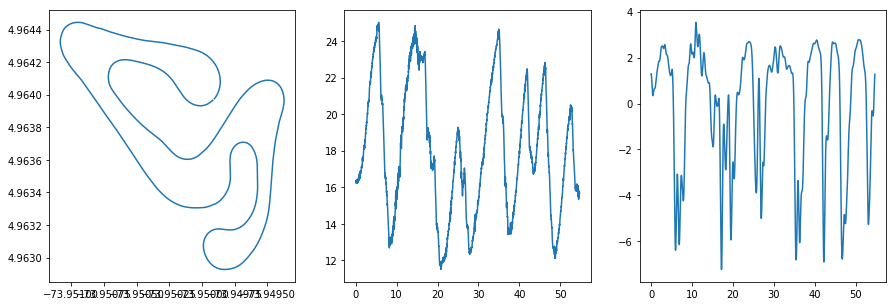

In [19]:
acelyvel('Data','VBOX0020.VBO',30,5500,2)

In [36]:
def TyP(carpeta,base,i0,i1,electricocombustion):
    #para electricocombustion= 1 es electrico y 2 es mecanico
    c=cortardatos(carpeta,base,i0,i1)
    o=omega(z['Velocidad'])
    
    if electricocombustion==1:
        a=accel(z['Velocidad'],z['dt'],10)
        t=torque(c['Velocidad'],a)
    
    
    else:
        a=accel(z['Velocidad'],z['dt'],20)
        t=torque(c['Velocidad'],a)
    
    
    P=t*o
    
    figure(figsize(15,5))
    plt.subplot(1,3,1)
    plot(c['Tiempo'],t)
    plt.subplot(1,3,2)
    plot(c['Tiempo'],o)
    plt.subplot(1,3,3)
    plot(o,t)
    

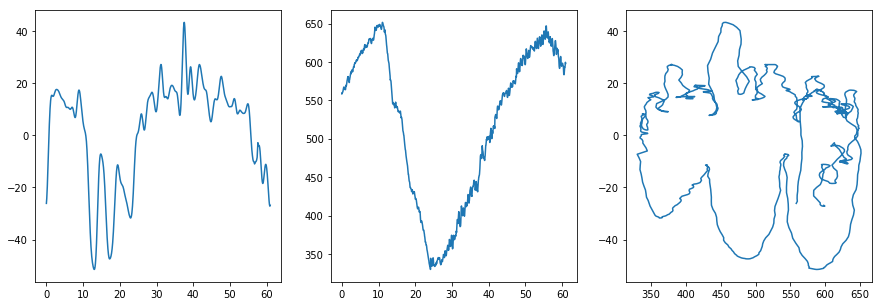

In [37]:
TyP('data_electrico','VBS__047.VBO',370,1590,1)

array([-2.08311801, -2.00523186, -1.92239329, ..., -2.2859521 ,
       -2.22356892, -2.15593078])

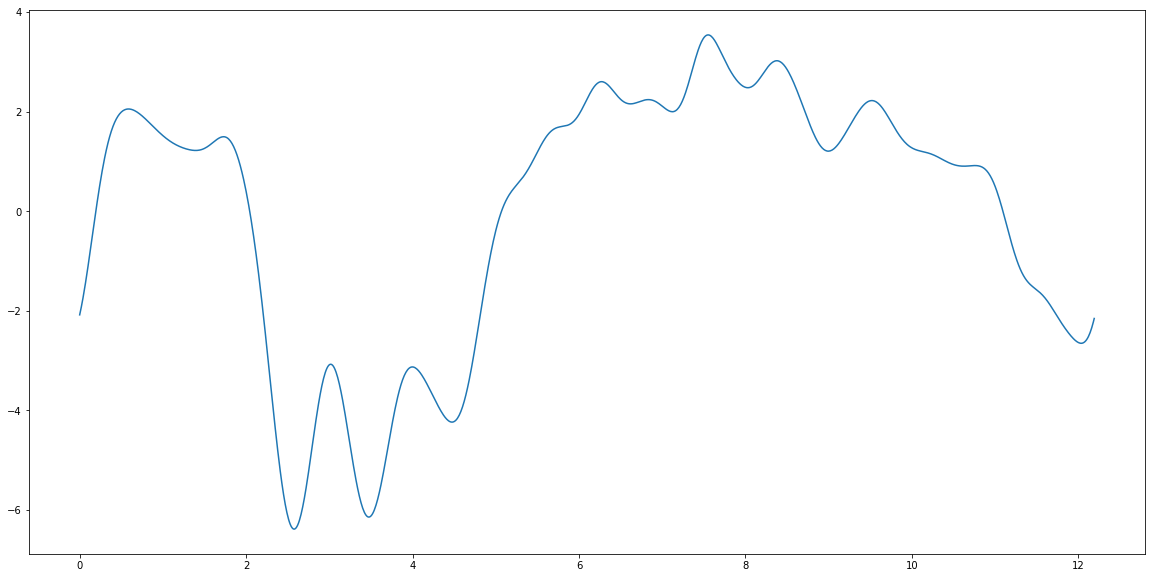

In [11]:






TyP('data_electrico','VBS__047.VBO',370,1590,1)
z=cortardatos('Data','VBOX0020.VBO',370,1590)


grafica=plt.plot(z['Tiempo'],accel(z['Velocidad'],z['dt'],20))
x=accel(z['Velocidad'],z['dt'],20)


In [12]:
z=cortardatos('Data','VBOX0020.VBO',370,1590)
z['dt']

0.010000000002037268

In [13]:
e=cortardatos('data_electrico','VBS__047.VBO',370,1590)
    c=cortardatos('Data','VBOX0020.VBO',370,1590)

IndentationError: unexpected indent (<ipython-input-13-47ec5a56ba6c>, line 2)